In [3]:
from lib.all import all_in_one
from lib.show import compare_repartition, histo_continuous, show_hyperparam_opti
from lib.train import iterate_params, choose_params, nb_possibility
from lib.prepare_data import make_cut, to_categorical
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import os
import sys
import warnings


from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning) 

In [4]:
os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] = "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

spark = SparkSession \
    .builder \
    .appName("renovation") \
    .getOrCreate()

# set this parameter for date issue before 1582 (dpe database)
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [5]:
# import files
# File location and type
file_location_array = [
    {"location": "./training/pred_tremi.csv",
        "name": "pred_tremi_full", "delimiter": ","},
    {"location": "./training/dico.csv", "name": "dictionary", "delimiter": "\t"}
]
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
dataframes = {}

# The applied options are for CSV files. For other file types, these will be ignored.
for file in file_location_array:
    delimiter = file["delimiter"]
    file_location = file["location"]
    name = file["name"]
    dataframes[file["name"]] = (
        spark.read.format(file_type)
        .option("inferSchema", infer_schema)
        .option("header", first_row_is_header)
        .option("sep", delimiter)
        .load(file_location)
    )

In [6]:
# name the important datasets and cast to type
training_tremi = (
    dataframes['pred_tremi_full'].withColumns({
        'surface': F.col('surface').cast('float'),
        'heating_production': F.col('heating_production').cast('int'),
        'heating_emission': F.col('heating_emission').cast('int')
    })
)

dictionary = dataframes['dictionary']

In [7]:
# split training and prediction datasets
training_surf = training_tremi.filter(F.col('surface').isNotNull()).drop(
    'heating_emission', 'heating_production')
predicting_surf = training_tremi.filter(F.col('surface').isNull()).drop(
    'heating_emission', 'heating_production')

training_prod = training_tremi.filter(
    F.col('heating_production').isNotNull()).drop('heating_emission', 'surface')
predicting_prod = training_tremi.filter(
    F.col('heating_production').isNull()).drop('heating_emission', 'surface')

training_em = training_tremi.filter(
    F.col('heating_emission').isNotNull()).drop('surface', 'heating_production')
predicting_em = training_tremi.filter(
    F.col('heating_emission').isNull()).drop('surface', 'heating_production')

print(f"""
{training_surf.count() =}
{predicting_surf.count() =}\n
{training_prod.count() =}
{predicting_prod.count() =}\n
{training_em.count() =}
{predicting_em.count() =}
""")


training_surf.count() =12565
predicting_surf.count() =26933

training_prod.count() =11128
predicting_prod.count() =28370

training_em.count() =12558
predicting_em.count() =26940



# ML

In [8]:
# librairies
import numpy as np
import matplotlib.pyplot as plt

# usefull
from copy import deepcopy

# linear
from sklearn.linear_model import LogisticRegression

# random forest
from sklearn.ensemble import RandomForestClassifier

# XGboost
from xgboost.sklearn import XGBClassifier

# HistGboost
from sklearn.ensemble import HistGradientBoostingClassifier

#hyperparams
from scipy.stats import uniform, randint

# make cut Surf

In [9]:
# make the best split
best_cut=(70,45,1)
cuts = make_cut(*best_cut)
training_surf, coef = to_categorical(training_surf, 'surface', cuts)

## surface

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 6
min_resources_: 24
max_resources_: 12565
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 100
n_resources: 24
Fitting 4 folds for each of 100 candidates, totalling 400 fits
----------
iter: 1
n_candidates: 34
n_resources: 72
Fitting 4 folds for each of 34 candidates, totalling 136 fits
----------
iter: 2
n_candidates: 12
n_resources: 216
Fitting 4 folds for each of 12 candidates, totalling 48 fits
----------
iter: 3
n_candidates: 4
n_resources: 648
Fitting 4 folds for each of 4 candidates, totalling 16 fits
----------
iter: 4
n_candidates: 2
n_resources: 1944
Fitting 4 folds for each of 2 candidates, totalling 8 fits
0.5717503217503217 {'C': 612.8528947223795, 'class_weight': 'balanced', 'max_iter': 1000}
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 6
min_resources_: 24
max_resources_: 12565
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 100
n_resources

ValueError: Invalid parameter 'n_estimators' for estimator HistGradientBoostingClassifier(l2_regularization=0.3745401188473625,
                               learning_rate=0.3152142919229748, max_depth=11). Valid parameters are: ['categorical_features', 'class_weight', 'early_stopping', 'interaction_cst', 'l2_regularization', 'learning_rate', 'loss', 'max_bins', 'max_depth', 'max_iter', 'max_leaf_nodes', 'min_samples_leaf', 'monotonic_cst', 'n_iter_no_change', 'random_state', 'scoring', 'tol', 'validation_fraction', 'verbose', 'warm_start'].

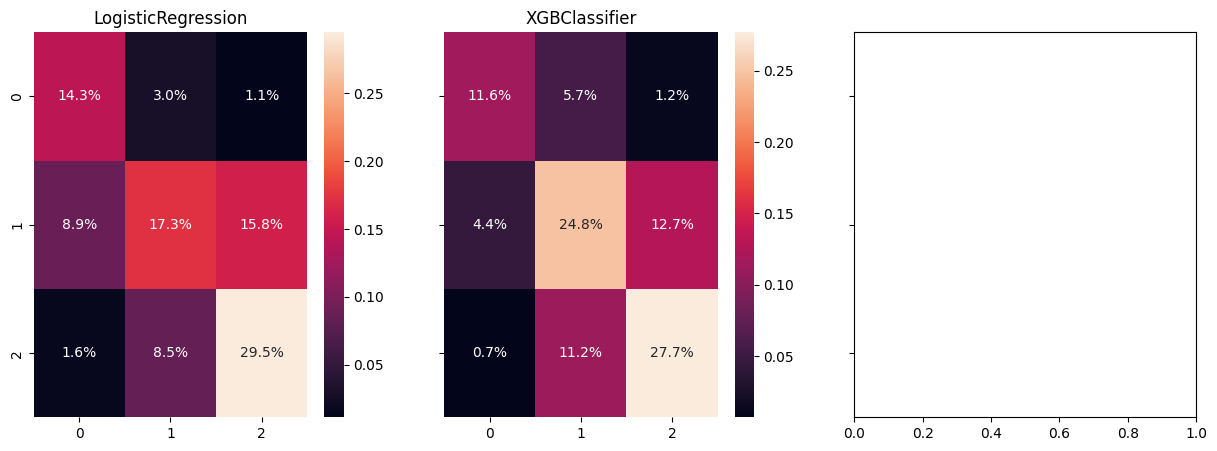

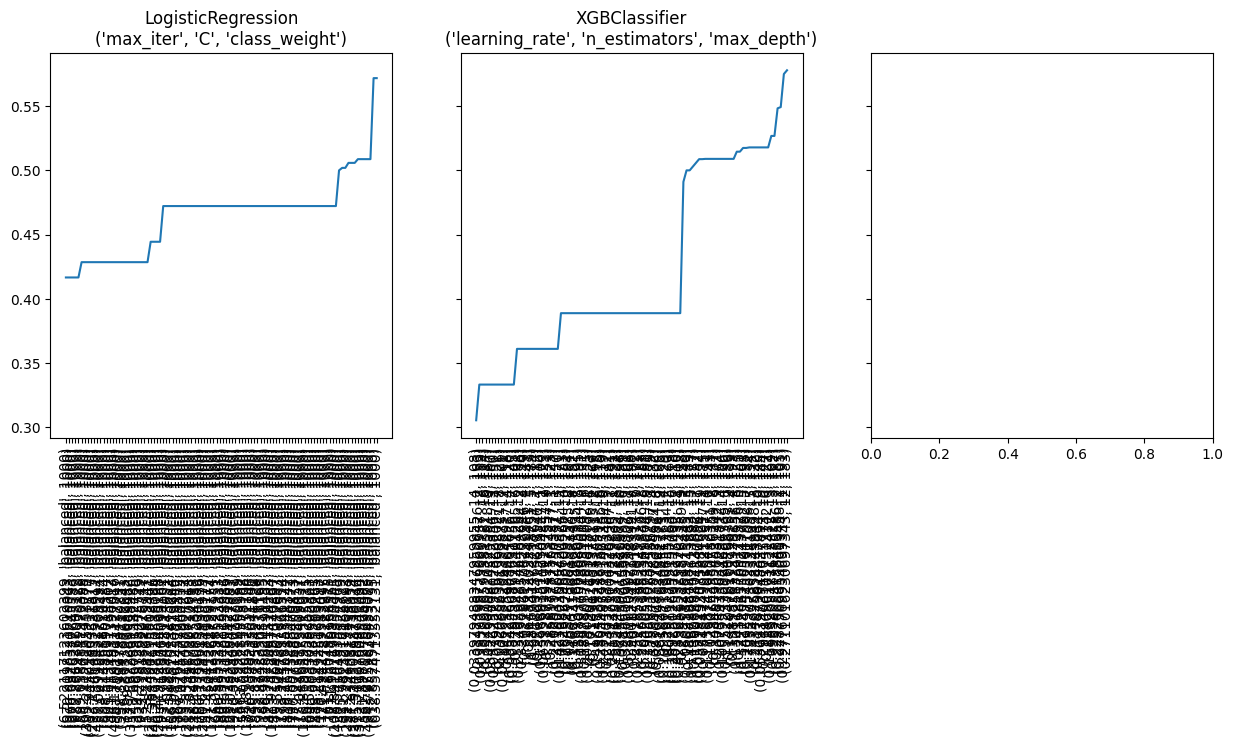

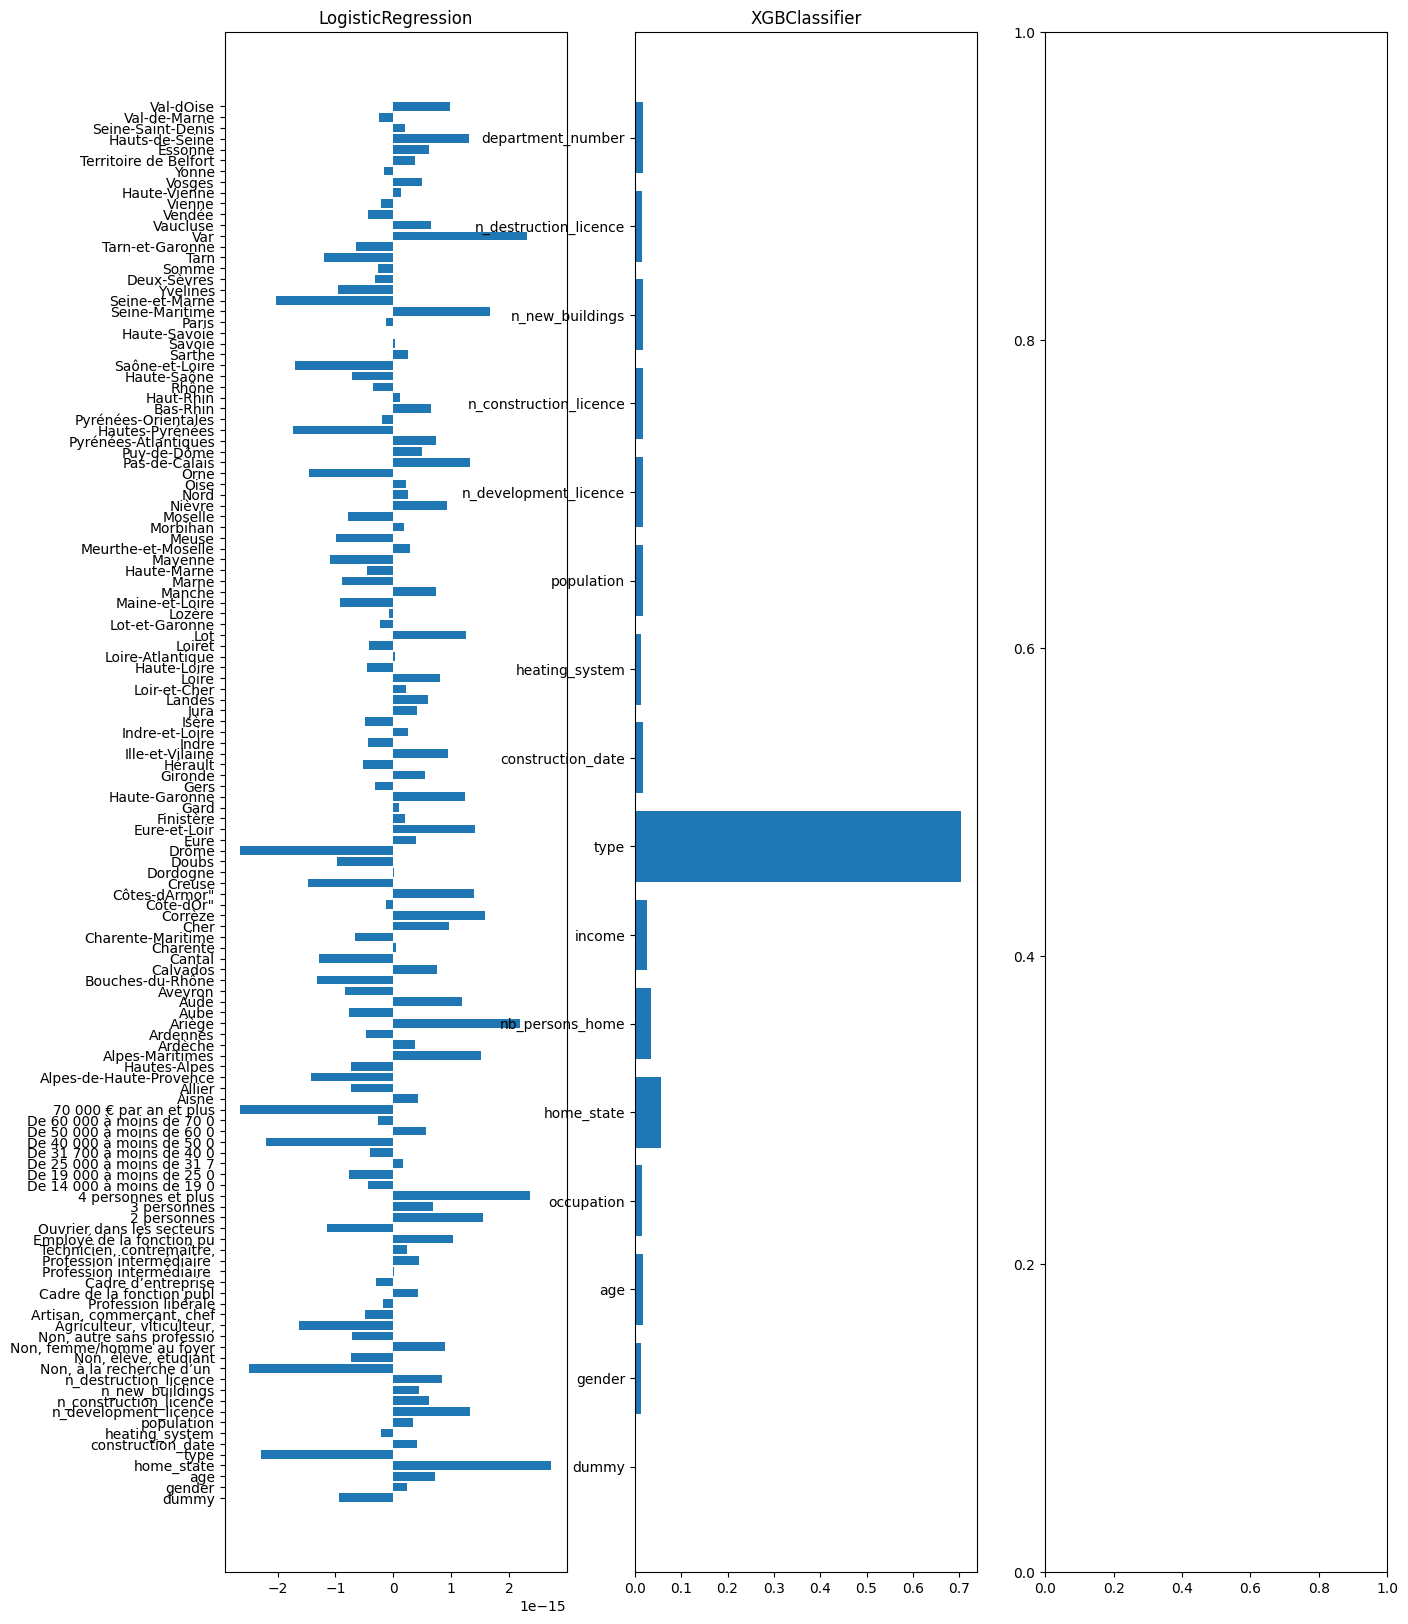

In [10]:
col_X_hot = [['occupation', 'nb_persons_home',
              'income', 'department_number'], [], []]
col_y = ['surface']
col_X_not_hot = [
    [col[0] for col in training_surf.dtypes if col[0] not in col_X_hot[0] + col_y],
    [col[0] for col in training_surf.dtypes if col[0] not in col_X_hot[1] + col_y],
    [col[0] for col in training_surf.dtypes if col[0] not in col_X_hot[2] + col_y]
]

hyperparams_models = [
    {
        'max_iter': [1000],
        'C': uniform(1,1000),
        'class_weight': ['balanced'],
    },
    {
        'learning_rate': uniform(0.03,0.3),
        'n_estimators': randint(100,200),
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        'max_depth': randint(1,20),
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    },
    {
        'learning_rate': uniform(0.03,0.3),
        'n_estimators': randint(100,200),
        'l2_regularization' : uniform(0,1),
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        'max_depth': randint(1,20),
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    }
]
models = {
    'LogisticRegression': LogisticRegression,
    'XGBClassifier': XGBClassifier,
    'HistGradientBoostingClassifier' : HistGradientBoostingClassifier,
}
best_models = all_in_one(training_surf, dictionary, col_X_hot, col_X_not_hot, col_y,
                         False, True, hyperparams_models, models, degree_poly=1, random_state=42, test_size=0.4)

## heating_production 

4
0 {'max_iter': 300, 'C': 1, 'class_weight': 'balanced'}


c:\Users\arocheteau\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2 {'max_iter': 300, 'C': 100, 'class_weight': 'balanced'}
0.30519991015274034 {'max_iter': 300, 'C': 0.1, 'class_weight': 'balanced'}
6
0 {'n_estimators': 200, 'max_depth': 10, 'class_weight': 'balanced'}
2 {'n_estimators': 200, 'max_depth': 35, 'class_weight': 'balanced'}
4 {'n_estimators': 200, 'max_depth': None, 'class_weight': 'balanced'}
0.4599056603773585 {'n_estimators': 200, 'max_depth': None, 'class_weight': 'balanced'}


KeyboardInterrupt: 

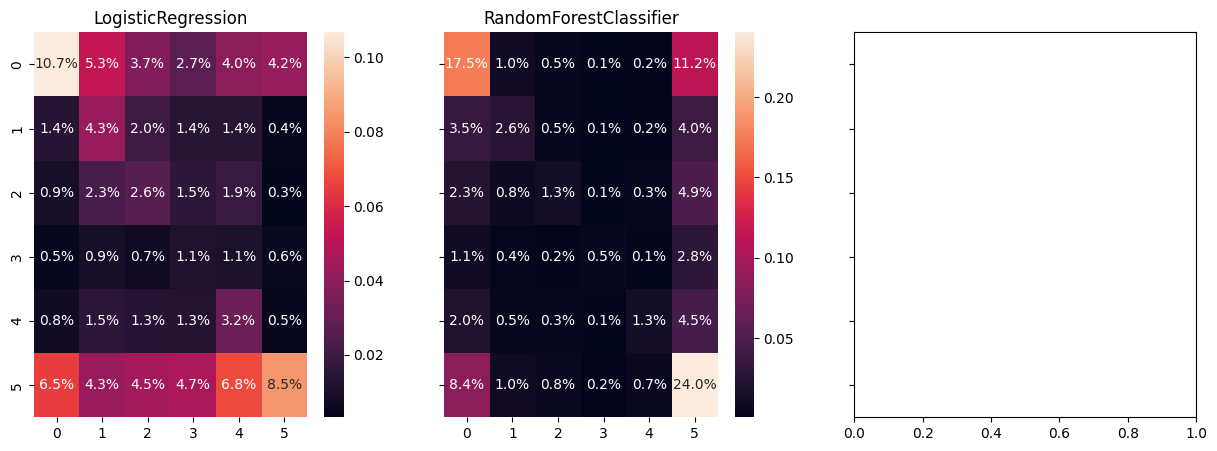

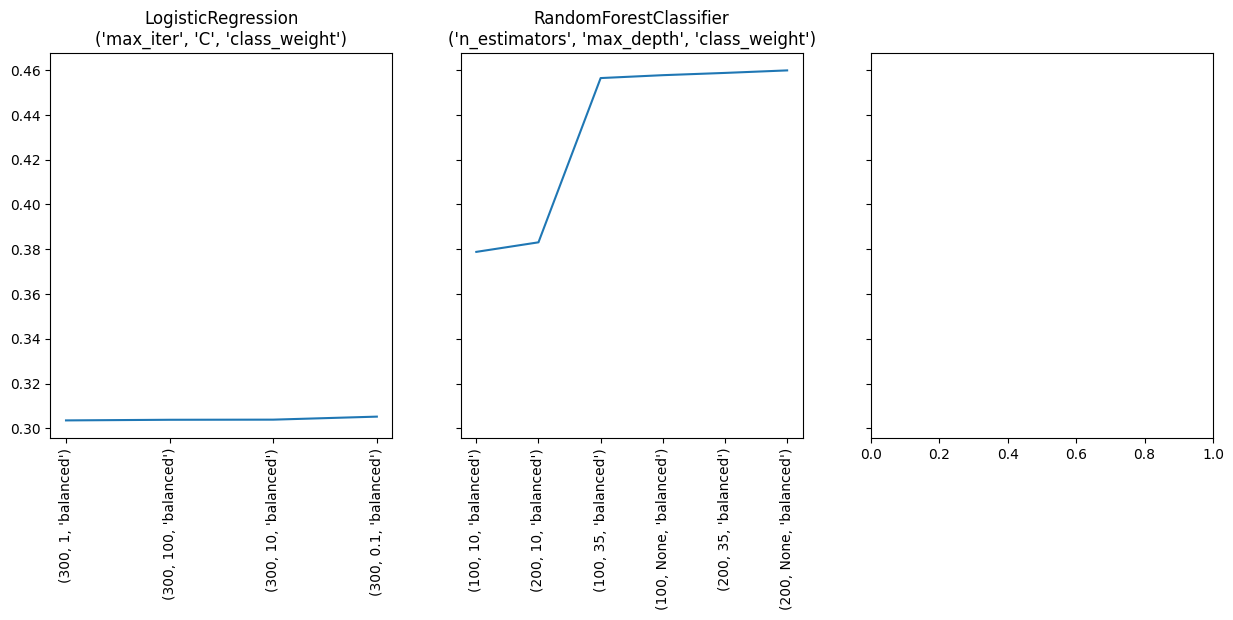

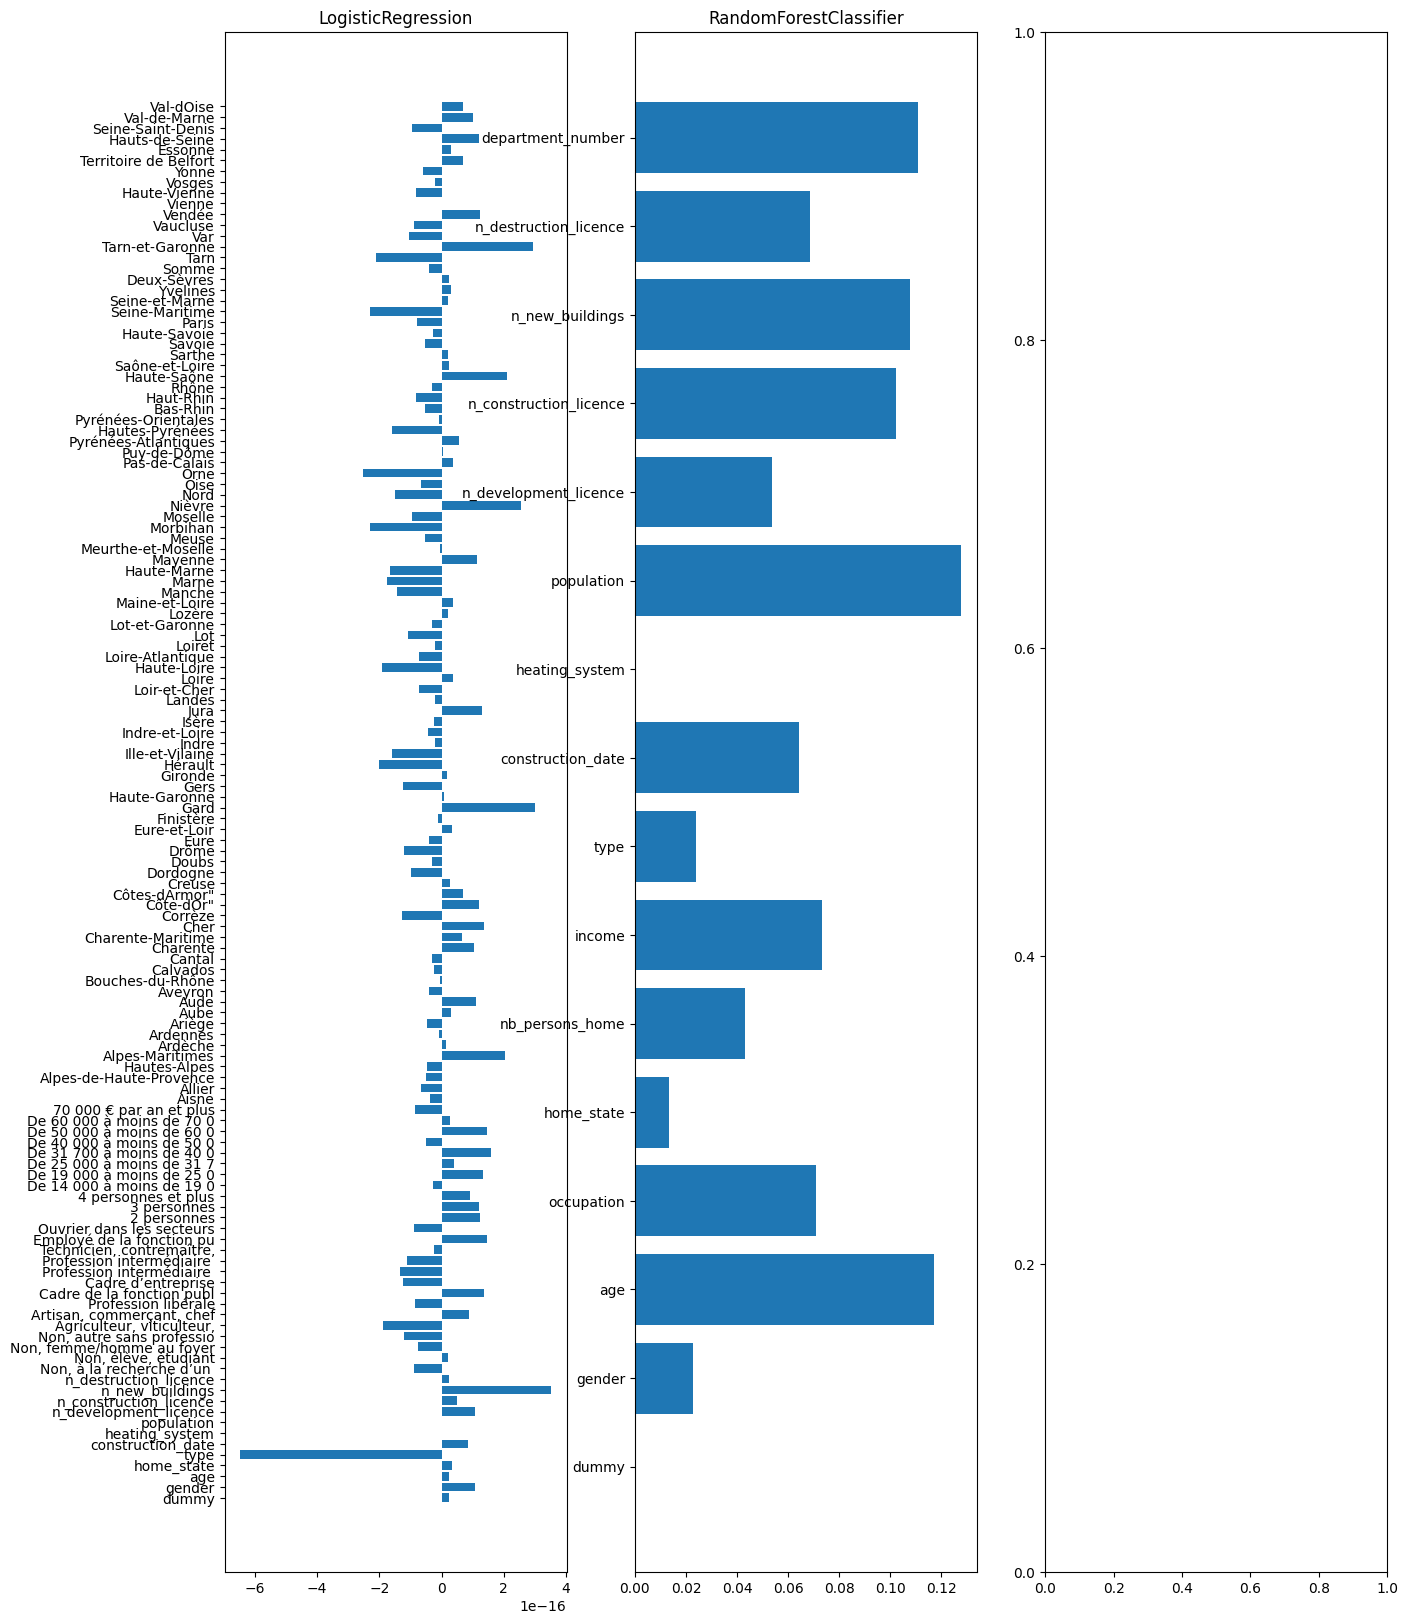

In [ ]:
col_X_hot = [['occupation', 'nb_persons_home',
              'income', 'department_number'], [], []]
col_y = ['heating_production']
col_X_not_hot = [
    [col[0] for col in training_prod.dtypes if col[0] not in col_X_hot[0] + col_y],
    [col[0] for col in training_prod.dtypes if col[0] not in col_X_hot[1] + col_y],
    [col[0] for col in training_prod.dtypes if col[0] not in col_X_hot[2] + col_y]
]

hyperparams_models = [
    {
        'max_iter': [300],
        'C': [0.1, 1, 10, 100],
        'class_weight': ['balanced'],
    },
    {
        'n_estimators': [100, 200],
        # 'criterion' : ["squared_error", "absolute_error", "friedman_mse"],
        'max_depth': [10, 35, None],
        'class_weight': ['balanced'],
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
        # 'max_features' : ["sqrt", "log2", "auto"]
    },
    {
        'learning_rate': [0.05, 0.1, 0.2],
        'n_estimators': [50, 100, 200],
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        'max_depth': [3, 5, 10],
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    }
]
models = {
    'LogisticRegression': LogisticRegression,
    'RandomForestClassifier': RandomForestClassifier,
    'GradientBoostingClassifier': GradientBoostingClassifier
}
best_models = all_in_one(training_prod, dictionary, col_X_hot, col_X_not_hot, col_y,
                         False, True, hyperparams_models, models, degree_poly=1, random_state=42, test_size=0.4)

## heating_emission

In [ ]:
col_X_hot = [['occupation', 'nb_persons_home',
              'income', 'department_number'], [], []]
col_y = ['heating_emission']
col_X_not_hot = [
    [col[0] for col in training_em.dtypes if col[0] not in col_X_hot[0] + col_y],
    [col[0] for col in training_em.dtypes if col[0] not in col_X_hot[1] + col_y],
    [col[0] for col in training_em.dtypes if col[0] not in col_X_hot[2] + col_y]
]

hyperparams_models = [
    {
        'max_iter': [300],
        'C': [0.1, 1, 10, 100],
        'class_weight': ['balanced'],
    },
    {
        'n_estimators': [100, 200],
        # 'criterion' : ["squared_error", "absolute_error", "friedman_mse"],
        'max_depth': [10, 35, None],
        'class_weight': ['balanced'],
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
        # 'max_features' : ["sqrt", "log2", "auto"]
    },
    {
        'learning_rate': [0.05, 0.1, 0.2],
        'n_estimators': [50, 100, 200],
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        'max_depth': [3, 5, 10],
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    }
]
models = {
    'LogisticRegression': LogisticRegression,
    'RandomForestClassifier': RandomForestClassifier,
    'GradientBoostingClassifier': GradientBoostingClassifier
}
best_models = all_in_one(training_em, dictionary, col_X_hot, col_X_not_hot, col_y, False,
                         True, hyperparams_models, models, degree_poly=1, random_state=42, test_size=0.4)